In [ ]:
import torch
from torch.utils.data import Dataset
import torchvision.transforms as transforms
import os
from PIL import Image
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import time
import glob
import yaml
import torchvision

In [ ]:
def extract_files():
    import google.colab
    import zipfile

    google.colab.drive.mount('/content/drive', force_remount=True)
    PROJECT_DIR = "/content/drive/MyDrive/thesis/data/"

    zip_ref = zipfile.ZipFile(PROJECT_DIR + "fiveK.zip", 'r')
    zip_ref.extractall(".")
    zip_ref.close()

In [ ]:
if 'google.colab' in str(get_ipython()):
  extract_files()
  config_path = "/content/drive/MyDrive/thesis/config.yaml"
else:
  config_path = "../../config.yaml"

Mounted at /content/drive


In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [ ]:
# List of class directories
class_directories = ['expA', 'expB', 'expC', 'expD', 'expE']

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, data_dir, filename, transform=None):
        super().__init__()
        self.filename = filename
        self.transform = transform
        self.classname = self._extract_class_name(data_dir)
        self.encode = {k: i for i, k in enumerate(class_directories)}

        # Read the train.txt file and store the image paths
        with open(self.filename) as f:
            self.image_paths = [os.path.join(data_dir, line.strip()) for line in f]

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, index):
        image_path = self.image_paths[index]
        image = Image.open(image_path)
        label = self.encode[self.classname]
        if self.transform is not None:
            image = self.transform(image)
        return image, label

    def _extract_class_name(self, root_dir):
        # Extract the class name from the root directory
        class_name = os.path.basename(root_dir)
        return class_name

In [ ]:
try:
    # Load configuration
    with open(config_path, 'r') as config_file:
        config = yaml.safe_load(config_file)
except:
    raise FileNotFoundError(f"Config file not found at path: {config_path}")

In [ ]:
data_folder = config['paths']['data']
train_file = config['paths']['train']
test_file = config['paths']['test']

In [ ]:
def read_dataset(data_folder, txt_file, trasform=None):
    # Create separate datasets for each class
    datasets = []

    for class_dir in class_directories:
        class_train_dataset = CustomDataset(
            data_dir=os.path.join(data_folder, class_dir),
            filename=os.path.join(txt_file),
            transform=trasform
        )
        datasets.append(class_train_dataset)
    return datasets

In [ ]:
training_tr = transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

test_tr = transforms.Compose([
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

In [ ]:
# Combine datasets if needed (e.g., for training)
train_dataset = torch.utils.data.ConcatDataset(read_dataset(data_folder, train_file, training_tr))
test_dataset = torch.utils.data.ConcatDataset(read_dataset(data_folder, test_file, test_tr))

In [ ]:
bs = 256


In [ ]:
train_dataloader = DataLoader(train_dataset, batch_size=bs, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=bs*2, shuffle=False)

In [ ]:
# unique_classes = set(class_label for _, class_label in train_dataset)

# # Print the unique classes
# print("All Classes:", unique_classes)

In [ ]:
train_features, train_labels = next(iter(train_dataloader))

In [ ]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

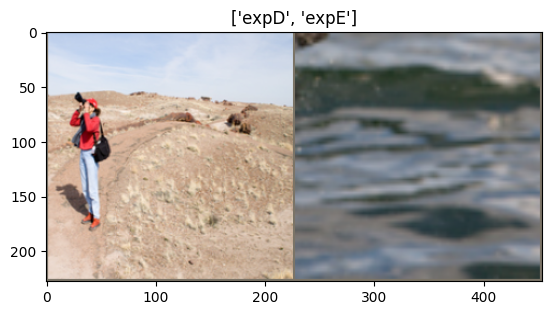

In [ ]:
# Get a batch of training data
inputs, labels = next(iter(train_dataloader))
# Make a grid from first 2 images in the batch
out = torchvision.utils.make_grid(inputs[:2])
imshow(out, title=[class_directories[x] for x in labels[:2]])

In [ ]:
print(len(train_dataset))

20000


In [ ]:
# https://stackoverflow.com/questions/42703500/how-do-i-save-a-trained-model-in-pytorch
# how to save the model
# https://pytorch.org/tutorials/recipes/recipes/saving_and_loading_a_general_checkpoint.html#:~:text=Load%20the%20general%20checkpoint,-Remember%20to%20first&text=eval()%20to%20set%20dropout,layers%20are%20in%20training%20mode.

In [ ]:
base_checkpoint_path = os.path.join(config['paths']['checkpoints'], 'resetnet34_fine_tunning')

# Create the directory if it does not exist
if not os.path.exists(base_checkpoint_path):
    os.makedirs(base_checkpoint_path)


In [ ]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

In [ ]:
def train_model(model, criterion, optimizer, scheduler, current_epoch, num_epochs=25):
    since = time.time()
    best_acc = 0.0
    model.train()
    for epoch in range(current_epoch, num_epochs):
            # formatted string to append epoch number to checkpoint filename
        print(f'Epoch {epoch + 1}/{num_epochs}')
        print('-' * 10)
        running_loss = 0.0
        running_corrects = 0
        # Iterate over data.
        for inputs, labels in train_dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        scheduler.step()

        epoch_loss = running_loss / len(train_dataset)
        epoch_acc = running_corrects.double() / len(train_dataset)

        print(f'Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} LR: {get_lr(optimizer):.8f}')
        print()

        PATH = os.path.join(base_checkpoint_path, f'resetnet34_fine_tunning_{epoch+1}.pth')
        # save checkpoint
        state = {
            'epoch': epoch + 1,
            'state_dict': model.state_dict(),
            'optimizer': optimizer.state_dict(),
            'loss': epoch_loss,
            'scheduler': scheduler.state_dict(),
            'accuracy': epoch_acc
        }
        # save the best model parameters
        torch.save(state, PATH)
        # deep copy the model
        if epoch_acc > best_acc:
            best_acc = epoch_acc

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best Acc: {best_acc:4f}')

In [ ]:
model = torchvision.models.resnet34(weights='IMAGENET1K_V1')

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 5)

# move the model to GPU/CPU
model = model.to(device)

criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

milestones = [10, 21, 36, 50, 70]

# Decay LR by a factor of 0.1 every 7 epochs
scheduler = lr_scheduler.MultiStepLR(optimizer, milestones, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:01<00:00, 72.0MB/s]


In [ ]:
# load the last model saved if there is any
def load_latest_model(model, optimizer, scheduler, checkpoint_dir):
    # Check if the directory exists
    if not os.path.exists(base_checkpoint_path):
        print(f"No directory found: {checkpoint_dir}")
        return model, optimizer, scheduler, 0, None

    # Get a list of all checkpoint files in the directory
    checkpoint_files = glob.glob(os.path.join(checkpoint_dir, 'resetnet34_fine_tunning_*.pth'))

    # Check if any checkpoint files are present
    if not checkpoint_files:
        print(f"No checkpoints found in the directory: {checkpoint_dir}")
        return model, optimizer, scheduler, 0, None

    # Find the latest checkpoint file based on the epoch number in the filename
    latest_checkpoint = max(checkpoint_files, key=os.path.getctime)

    # Load the latest checkpoint
    checkpoint = torch.load(latest_checkpoint, map_location=torch.device(device))
    model.load_state_dict(checkpoint['state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer'])
    scheduler.load_state_dict(checkpoint['scheduler'])
    epoch = checkpoint['epoch']
    loss = checkpoint['loss']
    print(checkpoint['accuracy'])

    print(f"Loaded model from checkpoint: {latest_checkpoint}")
    print(f"Resuming training from epoch {epoch}")

    return model, optimizer,scheduler, epoch, loss


In [ ]:
model, optimizer, scheduler, current_epoch, loss = load_latest_model(model, optimizer, scheduler, base_checkpoint_path)

tensor(0.4088, device='cuda:0', dtype=torch.float64)
Loaded model from checkpoint: /content/drive/MyDrive/thesis/model/checkpoints/resetnet34_fine_tunning/resetnet34_fine_tunning_2.pth
Resuming training from epoch 2


In [ ]:
print(get_lr(optimizer))

0.01


In [ ]:
train_model(model, criterion, optimizer, scheduler,current_epoch, num_epochs=40)

Epoch 3/40
----------
Loss: 1.3345 Acc: 0.4425 LR: 0.01000000

Epoch 4/40
----------
Loss: 1.2965 Acc: 0.4589 LR: 0.01000000

Epoch 5/40
----------
Loss: 1.2796 Acc: 0.4703 LR: 0.01000000

Epoch 6/40
----------
Loss: 1.2394 Acc: 0.4878 LR: 0.01000000

Epoch 7/40
----------
Loss: 1.2244 Acc: 0.4963 LR: 0.01000000

Epoch 8/40
----------
Loss: 1.2213 Acc: 0.4978 LR: 0.01000000

Epoch 9/40
----------
Loss: 1.1992 Acc: 0.5067 LR: 0.01000000

Epoch 10/40
----------
Loss: 1.1921 Acc: 0.5102 LR: 0.00100000

Epoch 11/40
----------
Loss: 1.1124 Acc: 0.5458 LR: 0.00100000

Epoch 12/40
----------
Loss: 1.0803 Acc: 0.5624 LR: 0.00100000

Epoch 13/40
----------
Loss: 1.0762 Acc: 0.5621 LR: 0.00100000

Epoch 14/40
----------
Loss: 1.0725 Acc: 0.5683 LR: 0.00100000

Epoch 15/40
----------
Loss: 1.0609 Acc: 0.5714 LR: 0.00100000

Epoch 16/40
----------
Loss: 1.0545 Acc: 0.5726 LR: 0.00100000

Epoch 17/40
----------
Loss: 1.0499 Acc: 0.5761 LR: 0.00100000

Epoch 18/40
----------
Loss: 1.0376 Acc: 0.5814